# Here comes the infection!

**Here comes the infection!**, es un juego dinámico que le permitirá al usuario observar la evolución de una infección pandémica dentro de una ciudad ficticia. Es un juego sin jugadores, esto significa que su evolución está determinada por los cambios de su estado. El juego estará compuesto de 2 categorías (sanos e infectados) cada uno con características y habilidades distintas. Las categorías se explicarán a continuación:

**Sanos (Representados por el color rojo):**

* Los ciudadanos sanos representarán 2/3 de la población actual.
* Estos se contagiarán al momento de estar en contacto con algún habitante infectado.

**Infectados (Representados por el color verde):**
* Los infectados representarán 1/3 de la población actual.
* Estos podrán contagiar a los demás habitantes al entrar en contacto con ellos.

<center>
<img src="https://images.theconversation.com/files/413153/original/file-20210726-25-1au81j5.jpg?ixlib=rb-1.1.0&rect=7%2C7%2C4975%2C3413&q=20&auto=format&w=320&fit=clip&dpr=2&usm=12&cs=strip" width=450 height=250/>
</center>

## Reglas

El universo (o entorno) de Here comes the infection es finito, cuadrícula ortogonal bidimensional de celdas cuadradas, cada una de ellas se encuentra con uno de dos posibles estados, vivo o infectado. Cada celda interactúa con ocho vecinos, que son las celdas adyacentes horizontales, verticales y diagonales. En cada turno, se seguirán las siguientes reglas:

1. Al inicio del juego todos los habitantes aparecerán en posiciones aleatorias y estas irán cambiando conforme pasen los turnos.
2. Cualquier ciudadano sano que interactue con algun infectado será contagiado.
3. Cualquier ciudadano sano que no entre en contacto con ningún infectado durante el turno, pasará al siguiente sin ser contagiado.
4. Cualquier infectado que pase 2 turnos sin estar en contacto con otro infectado volverá a su estado sano.
5. Cualquier ciudadano infectado que entre en contacto con algún otro infectado durante el turno se quedará en el mismo estado.


In [2]:
!python3 -m pip install mesa

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [3]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

## Crear el modelo

Antes que nada el presente modelo se encuentra basado en el [tutorial introductorio](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html). Se modificó para que funcionara con el presente problema pero en esencia es lo mismo.

In [4]:
class CitizenAgent(Agent):
    """
    Representa a un ciudadano o una celda con estado sano (0) o infectado (1)
    """
    def __init__(self, unique_id, model, state):
        super().__init__(unique_id, model)
        self.state = state  #Estado inicial: 0 para sano, 1 para infectado
        self.next_state = state #Proximo estado
        self.recovery = 0 # Turnos sin contacto con los infectados

    def step(self):  # Agente para interactuar con el entorno
        """
        Este método es el que calcula si el ciudadano seguirá sano o se infectará dependiendo el estado de sus vecinos.
        """

        neighbours = self.model.grid.get_neighbors(
            self.pos, # Posicion de agente, devuelve una tupla (x,y)
            moore=True,
            include_center=False)

        if self.state == 0:
          infected_neighbours = 0
          for agent in neighbours:
            if agent.state == 1: #Verifica si el ciudadano esta infectado
              infected_neighbours += 1 #Lo agrega a infected_neighbours

          if infected_neighbours > 0:
            self.next_state = 1 #Se contagia el ciudadano y cambia de estado

        else:
          contact = 0
          for agent in neighbours:
            if agent.state == 1:
              contact += 1
          if contact == 8:
              self.next_state = 1
          elif self.recovery >= 2:
              self.next_state = 0 # Se recupera si han pasado dos turnos sin contacto
          else:
              self.recovery += 1

    def advance(self):
        """
        Actualiza el estado al próximo
        """
        self.state = self.next_state

class InfectionModel(Model):
    """
    Define el modelo de here comes the infection!.
    """
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.schedule = SimultaneousActivation(self)
        self.grid = SingleGrid(width, height, True)

        # Generar posiciones aleatorias para los agentes en la cuadricula
        agent_pos = np.random.choice(range(width * height), width * height, replace = False)

        # 2/3 serán sanos (0) y 1/3 serán infectados (1)
        sanos = int((width * height) * 2/3)

        for i, pos in enumerate(agent_pos):
          x = pos % width
          y = pos // width
          if i < sanos:
            state = 0 # Agregar ciudadanos sanos
          else:
            state = 1 # Agregar ciudadanos infectados

          agent = CitizenAgent(i, self, state)
          self.grid.place_agent(agent, (x, y))
          self.schedule.add(agent)

        self.datacollector = DataCollector(model_reporters={"Grid": self.get_grid, "ModelI": self.get_citizen}) # Aquí definimos el colector de datos para obtener el grid completo.


    def step(self):
        contact = 0 # Contacto con celdas infectadas

        self.datacollector.collect(self) # Recolección de datos

        for cell in self.grid.coord_iter():
          agent, pos = cell

          if agent.state == 0: # Si la celda esta sana
            neighbours = self.grid.get_neighbors(pos, moore = True, include_center=False)
            infected_neighbours = 0

            for neighbour in neighbours: # Se cuentan la cantidad de vecinos infectados
              if neighbour.state == 1:
                infected_neighbours += 1
                contact += 1

            if infected_neighbours > 0: # Si tiene vecinos infectados cambia al estado infectados (1)
              agent.next_state = 1
          else:
            if contact == 8: # Si la celda esta infectada y ha tenido contacto con alguno de sus vecinos cambia a infectado
              agent.next_state = 1
            else:
              if agent.recovery >= 2:
                agent.next_state = 0 # Se recupera si han pasado dos turnos sin contacto

        for cell in self.grid.coord_iter():
          agent, pos = cell
          agent.advance() # Se realiza el avance de sus estados al siguiente paso

    def get_citizen(self):
      healthy = 0
      infected = 0

      # Por todas las celdas del grid
      for agent, pos in self.grid.coord_iter():
        if isinstance(agent, CitizenAgent):
          if agent.state == 0: # Si la celda esta sana se aumenta 1 al contador healthy
            healthy += 1
          elif agent.state == 1: # Si la celda esta infectada se aumenta 1 al contador infected
            infected += 1

      return {"ModelI": {"Healthy": healthy, "Infected": infected}}


    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, pos = cell
            x, y = pos
            grid[x][y] = cell_content.state

        return grid

# Ejecución del modelo
A continuación corremos el modelo

In [11]:
# Definimos el tamaño del Grid ..> 7 x 7
GRID_SIZE = 100

model = InfectionModel(GRID_SIZE, GRID_SIZE)

# Variable para almacenar el número de turnos
TURNS = 0

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

while True:
    model.step()
    TURNS += 1

    # Verificar si no hay más agentes sanos en el juego
    if len([agent for agent in model.schedule.agents if agent.state == 0]) == 0:
      break

final_time = time.time()

# Imprimimos el número de turnos
print('Número de turnos: ', TURNS)
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Número de turnos:  2
Tiempo de ejecución: 0:00:00.724532


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [12]:
all_grids = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [13]:
all_grids

,Grid,ModelI
0,"[[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0,...","{'ModelI': {'Healthy': 6666, 'Infected': 3334}}"
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","{'ModelI': {'Healthy': 233, 'Infected': 9767}}"


In [14]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

colors = []
colors.append(np.array([255 / 255, 0 / 255, 0 / 255, 1])) # Rojos sanos
colors.append(np.array([0 / 255, 255 / 255, 0 / 255, 1])) # Verdes infectados
#colors.append(np.array([120 / 255, 255 / 255, 120 / 255, 1]))
#colors.append(np.array([40 / 255, 40 / 255, 40 / 255, 1]))
colormap = mlp.colors.ListedColormap(colors)

patch_grid = axs.imshow(all_grids['Grid'].iloc[0], cmap=colormap, vmin=0, vmax=1)

citizens = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])

    modelI = all_grids['ModelI'].iloc[i]['ModelI']
    sanos = modelI['Healthy']
    infectados = modelI['Infected']

    citizens.append(f"Sanos: {sanos}, Infectados: {infectados} ")

anim = animation.FuncAnimation(fig, animate, frames=TURNS)

In [15]:
anim

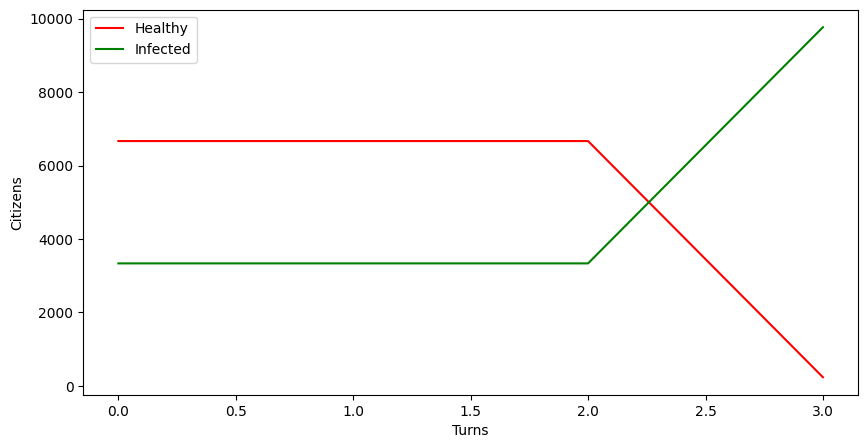

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axs.set_xlabel("Turns")
axs.set_ylabel("Citizens")

turns = list(range(len(citizens)))
healthy = [int(citizen.split(",")[0].split(":")[1]) for citizen in citizens]
infected = [int(citizen.split(",")[1].split(":")[1]) for citizen in citizens]

plt.plot(turns, healthy, label='Healthy', color='Red')
plt.plot(turns, infected, label='Infected', color='Green')
plt.legend()
plt.show()

# Batch simulation

In [18]:
NUM_REPS = 100
GRID_SIZE = 10
TURNS = 100

model = InfectionModel(GRID_SIZE, GRID_SIZE)

batch_data = {'time' : [], 'healthy' : [], 'infected' : []}
for _ in range(NUM_REPS):
    start_time = time.time()

    healthy = []
    infected = []
    for i in range(TURNS):
        model.step()
        mod = model.get_citizen()
        healthy.append(mod['ModelI']['Healthy'])
        infected.append(mod['ModelI']['Infected'])
    final_time = time.time()

    "all_grids = model.datacollector.get_model_vars_dataframe()"

    batch_data['time'].append(final_time - start_time)
    batch_data['healthy'].append(healthy)
    batch_data['infected'].append(infected)


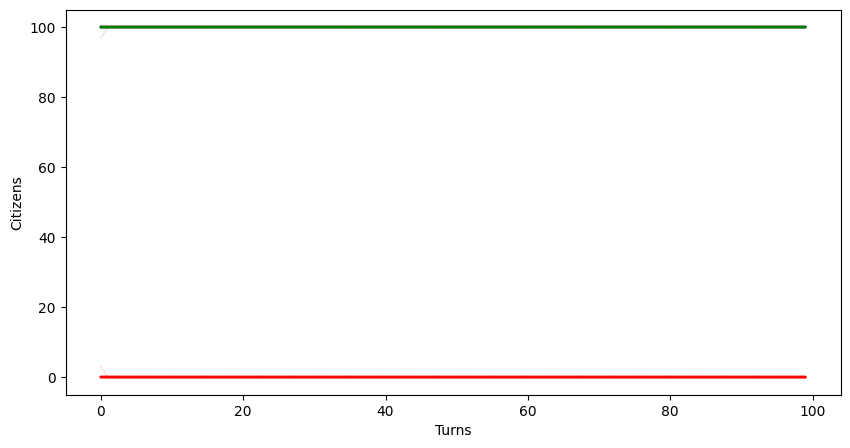

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Turns")
axs.set_ylabel("Citizens")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['healthy'], color='Red', alpha=0.1)
plt.plot(batch_data['infected'], color='Green', alpha=0.1)

plt.plot(np.average(np.array(batch_data['healthy']), axis=1), color='Red')
plt.plot(np.average(np.array(batch_data['infected']), axis=1), color='Green')
plt.plot(np.median(np.array(batch_data['healthy']), axis=1), color='Red', linestyle='dashed')
plt.plot(np.median(np.array(batch_data['infected']), axis=1), color='Green', linestyle='dashed')

plt.show()